<a href="https://www.kaggle.com/code/abdelrahmanfakre/faceemotiondetectiondeepface?scriptVersionId=159313869" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

test_data_dir = "/kaggle/input/fer2013/test"
train_data_dir = "/kaggle/input/fer2013/train"

train_dataset = image_dataset_from_directory(
    train_data_dir,
    labels='inferred',
    image_size=[48, 48],
    interpolation='nearest',
    batch_size=32,
    shuffle=True,
)

test_dataset = image_dataset_from_directory(
    test_data_dir,
    labels='inferred',
    image_size=[48, 48],
    interpolation='nearest',
    batch_size=32,
    shuffle=False,
)

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


label  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(32,), dtype=int32)


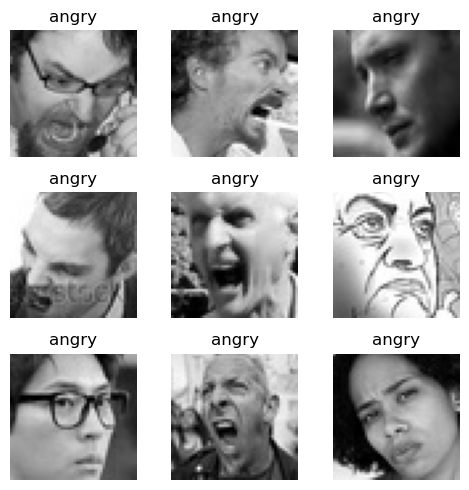

In [4]:
import matplotlib.pyplot as plt
# Get a batch of images from the dataset
for images, labels in test_dataset.take(1):
    # Plot the first 9 images in the batch
    fig, axs = plt.subplots(3, 3, figsize=(5, 5))
    axs = axs.flatten()
    print("label ", labels)
    idx = 0
    for img, ax in zip(images[:9], axs):
        ax.imshow(img.numpy().astype("uint8"))
        ax.set_title(test_dataset.class_names[labels[idx]])
        idx+=1
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
print("class names test dataset",test_dataset.class_names)
print("class names train dataset",train_dataset.class_names)

class names test dataset ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
class names train dataset ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [6]:
# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = (
    train_dataset
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
test_valid = (
    test_dataset
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # rescale pixel values to [0,1]
    rotation_range=30,  # rotate images randomly by up to 10 degrees
    width_shift_range=0.4,  # shift images horizontally by up to 40%
    height_shift_range=0.4,  # shift images vertically by up to 40%
    shear_range=0.3,  # shear images by up to 30%
    zoom_range=0.3,  # zoom in on images by up to 30%
    horizontal_flip=True,  # flip images horizontally with 50% probability
    fill_mode='nearest'  # fill in any gaps in the images using the nearest pixel
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255
)
img_rows = 48
img_cols = 48
num_classes = 7
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    color_mode='grayscale',
    target_size=(img_rows,img_cols),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

test_generator = validation_datagen.flow_from_directory(
    test_data_dir,
    color_mode='grayscale',
    target_size=(img_rows,img_cols),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
from keras.applications import VGG16

img_rows = 48
img_cols = 48
num_classes = 7

# Load the VGG16 model
vgg16 = VGG16(weights=None,  include_top=False, input_shape=(img_rows, img_cols, 1))

# Freeze the layers in the base model
for layer in vgg16.layers:
    layer.trainable = False

model = keras.Sequential([
    vgg16,
])
# Head

model.add(Flatten())
model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes,kernel_initializer='he_normal'))
model.add(Activation('softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14713536  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                        

In [9]:
# Train the model

model = Sequential()

# Block-1


model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(img_rows,img_cols,1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(img_rows,img_cols,1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block-2 

model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block-3

model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block-4 

model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block-5

model.add(Flatten())
model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block-6

model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block-7

model.add(Dense(num_classes,kernel_initializer='he_normal'))
model.add(Activation('softmax'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation_3 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_2 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 activation_4 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_3 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                      

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

In [11]:

checkpoint = ModelCheckpoint('/kaggle/working/Face Emotion Recognition/Emotion_vgg.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)


callbacks = [checkpoint]


nb_train_samples = 28709
nb_validation_samples = 7178
epochs = 50
batch_size = 32

history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/50


2024-01-17 11:44:45.092146: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


897/897 [==============================] - ETA: 0s - loss: 2.1832 - accuracy: 0.1921
Epoch 1: val_loss improved from inf to 1.77888, saving model to /kaggle/working/Face Emotion Recognition/Emotion_vgg.h5
897/897 [==============================] - 232s 237ms/step - loss: 2.1832 - accuracy: 0.1921 - val_loss: 1.7789 - val_accuracy: 0.2531
Epoch 2/50
897/897 [==============================] - ETA: 0s - loss: 1.8262 - accuracy: 0.2334
Epoch 2: val_loss improved from 1.77888 to 1.76798, saving model to /kaggle/working/Face Emotion Recognition/Emotion_vgg.h5
897/897 [==============================] - 68s 76ms/step - loss: 1.8262 - accuracy: 0.2334 - val_loss: 1.7680 - val_accuracy: 0.2638
Epoch 3/50
897/897 [==============================] - ETA: 0s - loss: 1.7928 - accuracy: 0.2558
Epoch 3: val_loss did not improve from 1.76798
897/897 [==============================] - 70s 78ms/step - loss: 1.7928 - accuracy: 0.2558 - val_loss: 1.7885 - val_accuracy: 0.2521
Epoch 4/50
897/897 [===========